# Interactive Deep Colorization and its Application for Image Compression DEMO (TF 1.X)

A modern port of https://github.com/praywj/Interactive-Deep-Colorization-and-Compression.

Paper: https://www.computer.org/csdl/journal/tg/5555/01/09186041/1mP2JjLRhDy

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

## Merge Project (requires Google Drive Access!)

In [1]:
import sys
import os
# adjust path as required!

_BASE_PATH = ""
# google colab (create link of Paper_Sibiu to own drive first)
if 'google.colab' in str(get_ipython()):
    _BASE_PATH = "/content/drive/MyDrive/Paper_Sibiu/Interactive-Deep-Colorization-and-Compression-tf/"
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
# local
else:
    _BASE_PATH = "~/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/"


try:
    os.chdir(_BASE_PATH)
except FileNotFoundError as ex:
    # presumably already started in correct folder
    _BASE_PATH = ""
    # sys.path.extend(".")

sys.path.extend([_BASE_PATH])

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

if 'google.colab' in str(get_ipython()):
    # %tensorflow_version 1.x
    %tensorflow_version 2.x

import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio
from src.colorization import input_data, model

from src.dinterface.preprocess import run

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Limit to one GPU
gpus = tf.config.list_physical_devices('GPU')
gpus
try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


2022-03-14 11:54:06.360930: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 11:54:06.752001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:0b:00.0, compute capability: 6.1


In [4]:
# Limit memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


2022-03-14 11:58:45.399962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 11:58:45.813244: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:0b:00.0, compute capability: 6.1


## Run Pretrained Colorization Pipeline on Sample Image

**Step 1:** Prepare Sample Data

In [5]:
# _BASE_PATH = '/content/drive/MyDrive/Paper_Sibiu/Interactive-Deep-Colorization-and-Compression-tf/'

_EVAL_IMG_RGB = _BASE_PATH + 'res/eval/image_color_dir/'
_EVAL_THEME_RGB = _BASE_PATH + 'res/eval/theme_dir/'
_EVAL_MASK = _BASE_PATH + 'res/eval/theme_mask_dir/'
_EVAL_COLOR_MAP_DIR = _BASE_PATH + 'res/eval/color_map_dir/'
_EVAL_POINTS_RGB = _BASE_PATH + 'res/eval/local_dir/'
_EVAL_POINTS_MASK = _BASE_PATH + 'res/eval/local_mask_dir/'

_IMG_NAME = "20191106_165848_Lijiang_0934_crop_1024x1024.png"  # img_rgb.png

_IMG_SIZE_H = 1024  # 256
_IMG_SIZE_W = 1024  # 256

_IN_DIR = _EVAL_IMG_RGB
_OUT_DIR = _BASE_PATH + 'res/eval/'

# generate random global (6/7 possible colors) + local points (100 random colors)
# adjust to your needs
run(_IN_DIR, _OUT_DIR, num_points_pix=1000, num_points_theme=6, random_crop=False)

20191106_165848_Lijiang_0934_crop_1024x1024.png


**Step 2:** Visualize Data

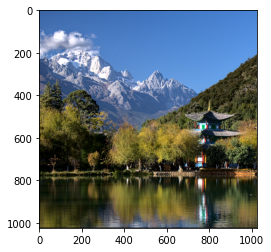

In [6]:
# original image
sample_img_BGR_orig = cv2.imread(_IN_DIR + _IMG_NAME)
sample_img_RGB_orig = cv2.cvtColor(sample_img_BGR_orig, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB_orig)
plt.show()

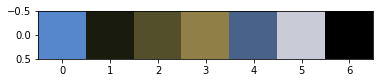

In [7]:
# theme image (kmeans colors)
sample_img_BGR = cv2.imread(_EVAL_THEME_RGB + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB)
plt.show()

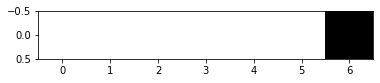

In [8]:
# theme image mask
sample_img_BGR = cv2.imread(_EVAL_MASK + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB)
plt.show()

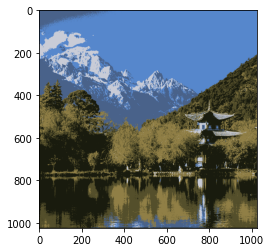

In [9]:
# color map
sample_img_BGR = cv2.imread(_EVAL_COLOR_MAP_DIR + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.imshow(sample_img_RGB)
plt.show()

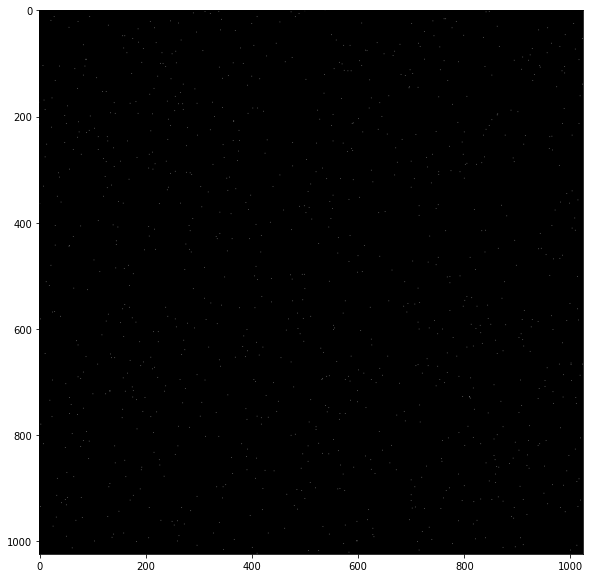

In [10]:
# simulated user inputs (boolean mask)
sample_img_BGR = cv2.imread(_EVAL_POINTS_MASK + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

# increase size, if pixels aren't visible, due to low resolution
plt.figure(figsize = (10,10))

plt.imshow(sample_img_RGB)
plt.show()

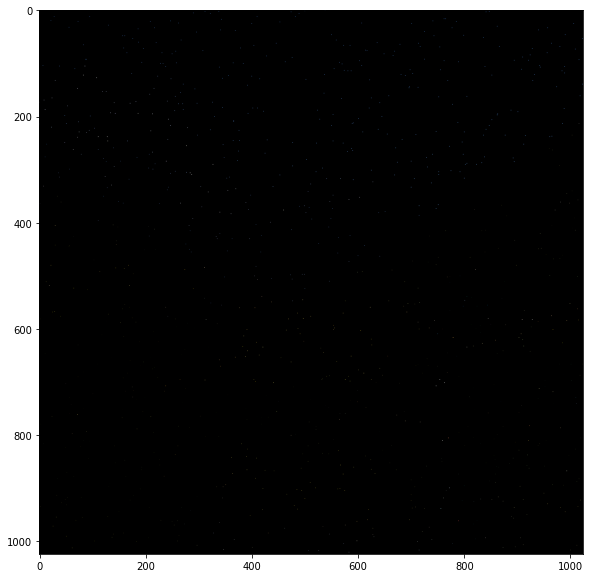

In [11]:
# simulated user colors (RGB)
sample_img_BGR = cv2.imread(_EVAL_POINTS_RGB + _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(sample_img_RGB)
plt.show()

**Step 3:** Run Colorization Pipeline

In [17]:
logs_ckpts_run_3 = _LOGS_DIR + 'run_3/'
logs_ckpts_run_3_tf2 = _LOGS_DIR + 'run_3_tf2/' 
logs_ckpts_run_3
ckpt = tf.train.get_checkpoint_state(logs_ckpts_run_3)

NameError: name '_LOGS_DIR' is not defined

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [12]:
_LOGS_DIR = _BASE_PATH + 'res/logs/'
_SAVE_PATH = _BASE_PATH + 'res/eval/'

def eval_colorization():
    capacity = 1000
    img_size_h, img_size_w = (_IMG_SIZE_H, _IMG_SIZE_W)
    batch_size = 1
    save_path = _SAVE_PATH + 'generated_color'
    # pretrained model
    logs_ckpts_run_3 = _LOGS_DIR + 'run_3/'
    logs_ckpts_run_3 = "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/res/logs/run_3/"

    # because of migration from tf 1.x -> 2.x
    tf.compat.v1.disable_eager_execution()
    sess = tf.compat.v1.Session()
    train_list = input_data.get_train_list(
        [_EVAL_IMG_RGB, _EVAL_THEME_RGB, _EVAL_MASK, _EVAL_COLOR_MAP_DIR, _EVAL_POINTS_RGB, _EVAL_POINTS_MASK],
        ['color img', 'theme img', 'theme mask', 'color_map img', 'local img', 'local mask'],
        ['*', '*', 'png', 'png', 'png', 'png'], shuffle=False)

    image_rgb_batch, theme_rgb_batch, theme_mask_batch, index_rgb_batch, point_rgb_batch, point_mask_batch = \
        input_data.get_batch(train_list, (img_size_h, img_size_w), batch_size, capacity, False)

    image_lab_batch = input_data.rgb_to_lab(image_rgb_batch)
    image_l_batch = tf.reshape(image_lab_batch[:, :, :, 0] / 100.0 * 2 - 1, [batch_size, img_size_h, img_size_w, 1])
    image_l_gra_batch = model.sobel(image_l_batch)

    theme_lab_batch = input_data.rgb_to_lab(theme_rgb_batch)
    theme_ab_batch = (theme_lab_batch[:, :, :, 1:] + 128.) / 255.0 * 2 - 1

    point_lab_batch = input_data.rgb_to_lab(point_rgb_batch)
    point_ab_batch = (point_lab_batch[:, :, :, 1:] + 128.) / 255.0 * 2 - 1

    # TODO: colorization
    out_ab_batch = model.inference3_1(image_l_batch, image_l_gra_batch, theme_ab_batch, theme_mask_batch,
                                      point_ab_batch, point_mask_batch,
                                      is_training=False, scope_name='UserGuide')
    # TODO: residual network
    _, out_ab_batch2 = model.gen_PRLNet(out_ab_batch, image_l_batch, 2, scope_name='PRLNet')
    test_rgb_out2 = \
        input_data.lab_to_rgb(
            tf.concat([(image_l_batch + 1.) / 2 * 100., (out_ab_batch2 + 1.) / 2 * 255. - 128], axis=3))

    var_list = tf.compat.v1.global_variables()
    var_model1 = [var for var in var_list if var.name.startswith('UserGuide')]
    var_model2 = [var for var in var_list if var.name.startswith('PRLNet')]
    var_total = var_model1 + var_model2
    paras_count1 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in var_model1])
    paras_count2 = tf.reduce_sum([tf.reduce_prod(v.shape) for v in var_model2])
    print('UserGuide Number of parameters 参数数目: %d' % sess.run(paras_count1))
    print('Detailed Number of parameters 参数数目: %d' % sess.run(paras_count2))

    saver1 = tf.compat.v1.train.Saver(var_list=var_total)
    print('Load checkpoint | 载入检查点...')
    ckpt = tf.train.get_checkpoint_state(logs_ckpts_run_3)
    # print(ckpt)
    if ckpt and ckpt.model_checkpoint_path:
        global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        saver1.restore(sess, ckpt.model_checkpoint_path)
        print('Loaded successfully | 载入成功, global_step = %s' % global_step)
    else:
        print('Failed to load | 载入失败')

    coord = tf.train.Coordinator()
    threads = tf.compat.v1.train.start_queue_runners(sess=sess, coord=coord)
    # compute the average psnr
    avg_psnr = 0.
    avg_ms_ssim = 0.
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    try:
        for t in range(len(train_list[0])):
            in_rgb, out_rgb2 = sess.run([image_rgb_batch, test_rgb_out2])
            in_rgb = in_rgb[0]
            out_rgb2 = out_rgb2[0]
            psnr = peak_signal_noise_ratio(out_rgb2, in_rgb)
            avg_psnr += psnr
            plt.imsave(save_path + '/' + train_list[0][t].split('/')[-1], out_rgb2)
            print('%s\n' % str(psnr))

        print('avg_psnr = %s' % str(avg_psnr / len(train_list[0])))

    except tf.errors.OutOfRangeError:
        print('Done.')
    finally:
        coord.request_stop()

    # Wait for the thread to end
    coord.join(threads=threads)
    sess.close()

In [13]:
eval_colorization()

[Type:color img][File nums: 1, Time_cost: 0.00s]
[Type:theme img][File nums: 1, Time_cost: 0.00s]
[Type:theme mask][File nums: 1, Time_cost: 0.00s]
[Type:color_map img][File nums: 1, Time_cost: 0.00s]
[Type:local img][File nums: 1, Time_cost: 0.00s]
[Type:local mask][File nums: 1, Time_cost: 0.00s]
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(tuple(tensor_list)).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.range(limit).shuffle(limit).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffl

2022-03-14 11:59:57.189952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:0b:00.0, compute capability: 6.1
/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/ops.py:45: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.compat.v1.layers.conv2d(inputs=inputs,
/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/ops.py:68: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please

========== UserGuide ==========
Img Inputs: Tensor("Reshape_3:0", shape=(1, 1024, 1024, 1), dtype=float32)
Theme Inputs: Tensor("concat:0", shape=(1, 1, 7, 3), dtype=float32)
Local Inputs: Tensor("concat_1:0", shape=(1, 1024, 1024, 3), dtype=float32)

ThemeBlock
Tensor("UserGuide/Reshape:0", shape=(1, 1, 1, 21), dtype=float32)
Tensor("UserGuide/glob_conv1/Relu:0", shape=(1, 1, 1, 512), dtype=float32)
Tensor("UserGuide/glob_conv2/Relu:0", shape=(1, 1, 1, 512), dtype=float32)
Tensor("UserGuide/glob_conv3/Relu:0", shape=(1, 1, 1, 512), dtype=float32)
Tensor("UserGuide/glob_conv4/Relu:0", shape=(1, 1, 1, 512), dtype=float32)

LocalBlock
Tensor("UserGuide/ab_conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/bw_conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/gra_conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)

ConvBlock 1
Tensor("UserGuide/conv1_1/Relu:0", shape=(1, 1024, 1024, 64), dtype=float32)
Tensor("UserGuide/conv1_2/Re

2022-03-14 12:00:00.754104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-14 12:00:01.107721: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-14 12:00:01.107770: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.03MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-14 12:00:01.107784: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.80MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more mem

NotFoundError: Graph execution error:

Detected at node 'UserGuide/bw_conv1_1/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/dakes/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/dakes/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10361/799395185.py", line 1, in <cell line: 1>
      eval_colorization()
    File "/tmp/ipykernel_10361/2200067632.py", line 35, in eval_colorization
      out_ab_batch = model.inference3_1(image_l_batch, image_l_gra_batch, theme_ab_batch, theme_mask_batch,
    File "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/model.py", line 303, in inference3_1
      bw_conv1_1 = conv2d(img_l_batch, ngf, 3, 1, activation_fn=tf.nn.relu,
    File "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/ops.py", line 45, in conv2d
      conv = tf.compat.v1.layers.conv2d(inputs=inputs,
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py", line 575, in conv2d
      return layer.apply(inputs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py", line 1683, in apply
      return self.__call__(inputs, *args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/base.py", line 569, in __call__
      outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py", line 765, in __call__
      outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'UserGuide/bw_conv1_1/conv2d/Conv2D'
Detected at node 'UserGuide/bw_conv1_1/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/dakes/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/dakes/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10361/799395185.py", line 1, in <cell line: 1>
      eval_colorization()
    File "/tmp/ipykernel_10361/2200067632.py", line 35, in eval_colorization
      out_ab_batch = model.inference3_1(image_l_batch, image_l_gra_batch, theme_ab_batch, theme_mask_batch,
    File "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/model.py", line 303, in inference3_1
      bw_conv1_1 = conv2d(img_l_batch, ngf, 3, 1, activation_fn=tf.nn.relu,
    File "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/ops.py", line 45, in conv2d
      conv = tf.compat.v1.layers.conv2d(inputs=inputs,
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py", line 575, in conv2d
      return layer.apply(inputs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py", line 1683, in apply
      return self.__call__(inputs, *args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/base.py", line 569, in __call__
      outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py", line 765, in __call__
      outputs = call_fn(cast_inputs, *args, **kwargs)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/dakes/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'UserGuide/bw_conv1_1/conv2d/Conv2D'
2 root error(s) found.
  (0) NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54525952 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16813568 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17621504 bytes.
	 [[{{node UserGuide/bw_conv1_1/conv2d/Conv2D}}]]
	 [[xyz_to_rgb/Reshape/_335]]
  (1) NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54525952 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16813568 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17621504 bytes.
	 [[{{node UserGuide/bw_conv1_1/conv2d/Conv2D}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'UserGuide/bw_conv1_1/conv2d/Conv2D':
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/dakes/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/home/dakes/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
    await self.process_one()
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
    await dispatch(*args)
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
    await result
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
    reply_content = await reply_content
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/dakes/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    result = self._run_cell(
  File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
    return runner(coro)
  File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/dakes/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10361/799395185.py", line 1, in <cell line: 1>
    eval_colorization()
  File "/tmp/ipykernel_10361/2200067632.py", line 35, in eval_colorization
    out_ab_batch = model.inference3_1(image_l_batch, image_l_gra_batch, theme_ab_batch, theme_mask_batch,
  File "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/model.py", line 303, in inference3_1
    bw_conv1_1 = conv2d(img_l_batch, ngf, 3, 1, activation_fn=tf.nn.relu,
  File "/home/dakes/Documents/ICDD/Interactive-Deep-Colorization-and-Compression/src/colorization/ops.py", line 45, in conv2d
    conv = tf.compat.v1.layers.conv2d(inputs=inputs,
  File "/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py", line 575, in conv2d
    return layer.apply(inputs)
  File "/home/dakes/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py", line 1683, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/base.py", line 569, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py", line 765, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 689, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 331, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 458, in _call_unconverted
    return f(*args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
    outputs = self.convolution_op(inputs, self.kernel)
  File "/home/dakes/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
    return tf.nn.convolution(
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py", line 1082, in op_dispatch_handler
    return dispatch_target(*args, **kwargs)
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 1148, in convolution_v2
    return convolution_internal(
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 1280, in convolution_internal
    return op(
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/ops/nn_ops.py", line 2756, in _conv2d_expanded_batch
    return gen_nn_ops.conv2d(
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 969, in conv2d
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 740, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3776, in _create_op_internal
    ret = Operation(
  File "/home/dakes/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2175, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


**Step 4:** Visualize Reconstruction/ Error Map

In [14]:
# reconstructed image
print(_SAVE_PATH + 'generated_color/' +  _IMG_NAME)
sample_img_BGR = cv2.imread(_SAVE_PATH + 'generated_color/' +  _IMG_NAME)
sample_img_RGB = cv2.cvtColor(sample_img_BGR, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(sample_img_RGB)
plt.show()

res/eval/generated_color/20191106_165848_Lijiang_0934_crop_1024x1024.png


[ WARN:0@93.979] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('res/eval/generated_color/20191106_165848_Lijiang_0934_crop_1024x1024.png'): can't open/read file: check file path/integrity


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


2022-03-14 12:00:14.106299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:0b:00.0, compute capability: 6.1
2022-03-14 12:00:14.229119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1603 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:0b:00.0, compute capability: 6.1


(1024, 1024)


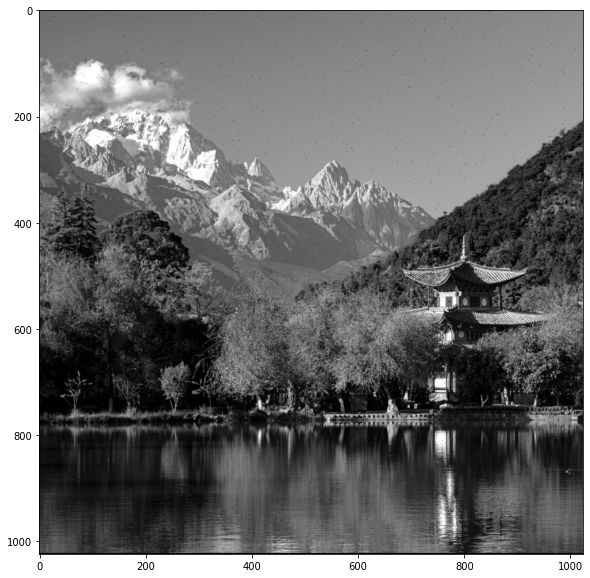

In [15]:
# absolute differences (white spots reveal largest error sections)
sample_img_RGB_orig = tf.cast(sample_img_RGB_orig, tf.float32)
sample_img_RGB = tf.cast(sample_img_RGB, tf.float32)

error_map_RGB = tf.reduce_mean(abs(sample_img_RGB_orig - sample_img_RGB), axis=-1)
tf.compat.v1.train.start_queue_runners
sess = tf.compat.v1.Session().run(error_map_RGB)
# error_map_RGB = tf.Session().run(error_map_RGB)
print(error_map_RGB.shape)

from tensorflow.python.keras import backend
sess = backend.get_session()
error_map_RGB_array = sess.run(error_map_RGB)

plt.figure(figsize = (10,10))
plt.imshow(error_map_RGB_array, cmap='gray')
plt.show()